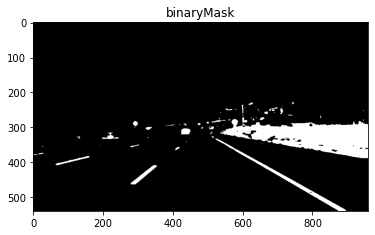

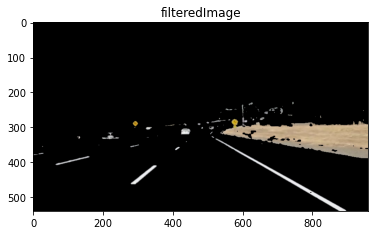

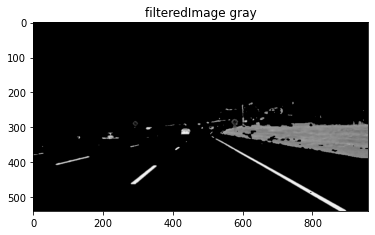

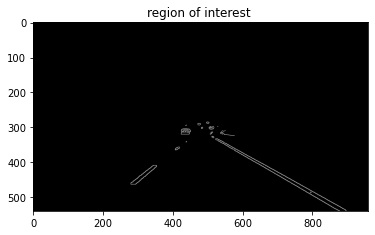

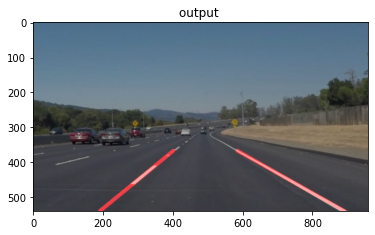

In [88]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random  
import os.path 
import math

img_name = 'test3.jpg' 
folder_name = 'dataset/'

filename, file_extension = os.path.splitext(img_name)

def read_image(image_name): 
    img = cv2.imread(image_name) 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img = read_image(folder_name+img_name) 


#conver image to HSV space 

def convert_hsv(image): 
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     img = np.full(image.shape, 1)
    return img

b = convert_hsv(img)
 
# ----------------------------------------------------------------------------------- 
# apply Gaussian
    
blur = cv2.GaussianBlur(b,(7,7),0)

# plt.figure() 
# plt.title('HSV')
# plt.imshow(output)
# cv2.imwrite('Result/'+filename+'_hsv.jpg', cv2.cvtColor(blur, cv2.COLOR_RGB2BGR))

# ----------------------------------------------------------------------------------- 
# create and apply mask

# for white
mask1 = cv2.inRange(blur, (0, 1, 130), (179, 15, 255))

# mask for yellow
mask2 = cv2.inRange(blur, (16,0,150), (32, 255, 255))

mask = cv2.bitwise_or(mask1, mask2)
output = cv2.bitwise_and(img,img, mask=mask)

plt.figure() 
plt.title('binaryMask') 
plt.imshow(mask, cmap='gray')
# cv2.imwrite('Result/'+filename+'_binaryMask.jpg', mask)
 
plt.figure() 
plt.title('filteredImage')
plt.imshow(output)
# cv2.imwrite('Result/'+filename+'_filteredImage.jpg', cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

# ----------------------------------------------------------------------------------- 
# apply Canny edge


h, s, gray = cv2.split(output) 

edges = cv2.Canny(gray,100,200)

plt.figure() 
plt.title('filteredImage gray') 
plt.imshow(gray, cmap='gray')
# cv2.imwrite('Result/'+filename+'_filteredImage_gray.jpg', gray)

# ----------------------------------------------------------------------------------- 
#Region of interest


def interested_region(img):
    height, width = img.shape 
    
    height_mid = height//2 
    width_mid = width//2 
    
    triangle = np.array([ [(0, height), (width, height), (width_mid, height_mid)] ])
    square = np.array([ [(0, height_mid), (0, height), (width, height),  (width, height_mid) ] ])

    mask1 = np.zeros_like(img)
    cv2.fillPoly(mask1, square, 255) 
    
    mask2 = np.zeros_like(img)
    cv2.fillPoly(mask2, triangle, 255)
    
    mask = cv2.bitwise_and(mask1, mask2)
    
    return cv2.bitwise_and(img, mask)

 
region_interest = interested_region(edges)
 

plt.figure() 
plt.title('region of interest ') 
plt.imshow(region_interest, cmap='gray')
# cv2.imwrite('Result/'+filename+'_roi.jpg', region_interest)


# ----------------------------------------------------------------------------------- 
# Hough transform

def calculate_max_rho(region_interest):
    h, w = region_interest.shape
    return np.sqrt(h*h + w*w)



def hough_transform(img):
    max_rho = int(calculate_max_rho(region_interest))
    min_rho = 0
    
    max_theta = 360
    theta_array = np.arange( -180, 180, 1)*np.pi/180
    
    A = np.zeros((max_theta, max_rho), dtype=np.uint8)
     
    height, width = region_interest.shape
    
    for y in range(0,height):
        for x in range(0,width):
            if (img[y, x] == 255):
                for i in range(max_theta):
                    theta = theta_array[i]
                    rho = round((x*np.cos(theta)) + (y*np.sin(theta)))
                    A[i, rho] = A[i, rho] + 1 
    return A

def thresholding(img, tl):
    img_height, img_width = img.shape
    thresholded_img = np.zeros((img_height, img_width))
    
    
    for i in range(img_height):
        for j in range(img_width):
            if img[i,j] > tl:
                thresholded_img[i,j] = 255
            else:  
                thresholded_img[i,j] = 0
                
    return thresholded_img

def find_values(thresholded_img, img):  
    new_img = np.zeros((img.shape[:2]))

    c = 1000  

    for i in range(thresholded_img.shape[0]):
        for j in range(thresholded_img.shape[1]):
            if thresholded_img[i,j] > tl:
                a = np.cos(i)
                b = np.sin(i)
                x0 = a * j
                y0 = b * j 
                x1 = int(x0 + c * (-b)) 
                y1 = int(y0 + c * (a)) 
                x2 = int(x0 - c * (-b)) 
                y2 = int(y0 - c * (a))
                cv2.line(new_img, (x1, y1), (x2, y2), [255, 255, 255], 5)
#                 print(x1, y1, x2, y2)
                
    return new_img



A = hough_transform(region_interest)

# plt.figure() 
# plt.imshow(A, cmap='jet') 

tl = 120

thresholded_img = thresholding(A, tl)

hough = find_values(thresholded_img, img)

# plt.figure() 
# plt.imshow(hough, cmap='gray') 

       
hough = cv2.HoughLinesP(region_interest, 2, np.pi / 180, 100, np.array([]), minLineLength = 5, maxLineGap = 100)

def draw_line(hough, img): 
    for i in hough:
        for x1,y1,x2,y2 in i:
            cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], 10)
    

def find_slope(hough, img):
    r, c = img.shape[:2]
    temp = np.zeros((r, c, 3), dtype=np.uint8)

    left = [] 
    right = []
    for i in hough:
        for x1,y1,x2,y2 in i:
            if x1 != x2:  
                slope = (y2 - y1) / (x2 - x1)
                c = y1 - slope * x1
                if slope > 0:
                    right.append((slope,c))
                elif slope <= 0:
                    left.append((slope,c))

                    
    left = np.average(left, axis=0)
    right = np.average(right, axis=0) 
     

    for i, j in [left, right]:
        rows, cols = img.shape
        
        y1= int(rows) 
        y2= int(y1*0.68)
        x1=int((y1-j)/i)
        x2=int((y2-j)/i) 
        
        draw_line(np.array([[[x1,y1,x2,y2]]]), temp)
    
    return temp
   
    
hough = cv2.HoughLinesP(region_interest, 2, np.pi / 180, 100, np.array([]), minLineLength = 5, maxLineGap = 100)


r, c = region_interest.shape[:2]

lined_img = np.zeros((r, c, 3), dtype=np.uint8) 
result = find_slope(hough,region_interest)
 
output = cv2.addWeighted(img,0.7,result,0.7,0.)

plt.figure() 
plt.title('output ') 
plt.imshow(output)
# cv2.imwrite('Result/'+filename+'_output.jpg', cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
